# Importer les librairies

In [25]:
# python -m venv venv
# source venv/bin/activate
# pip install -r requirements.txt

In [26]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_1samp
import statsmodels.api as sm

from scipy.stats import chi2_contingency

from scipy.stats import ttest_ind
import numpy as np

from scipy.stats import pearsonr

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

# Importer les données

In [27]:
data = pd.read_csv("Data/titanic.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Questions

## 1. Préparation des données

Remplissez la function `preprocess` ci-dessus. Celle-ci doit:
1. Supprimez les colonnes `PassengerId`, `Name`, `Ticket`, `Cabin`.
2. Supprimez les lignes contenant au moins une valeur manquante.
3. Créer une variable `FamilySize` qui est correspond à `SibSp` + `Parch` + 1. Supprimez les variables `SibSp` et `Parch`.
4. Recalculer le prix du billet `Fare` en divisant `Fare` par `FamilySize`.
5. Encoder les variables qualitatives `Sex`, `Embarked` avec l'argument `drop_first=True`.

In [28]:
def preprocess(data: pd.DataFrame) -> pd.DataFrame:
    """La fonction prépare les données à l'analyse.

    Args:
        data (pd.DataFrame): La dataframe originale

    Returns:
        pd.DataFrame: La dataframe preprocessée et prête à être analysée.
    """

    # Faire une copie de la dataframe originale
    data_preprocessed = data.copy()

    # Supprimez les variables `PassengerId`, `Name`, `Ticket` & `Cabin`
    data_preprocessed.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], inplace=True)

    # Supprimez les lignes contenant au moins une valeur manquante
    data_preprocessed.dropna(inplace=True)

    # Créer une variable `FamilySize` et supprimer les variables `SibSp` et `Parch`
    data_preprocessed["FamilySize"] = data_preprocessed["SibSp"] + data_preprocessed["Parch"] + 1
    data_preprocessed.drop(columns=["SibSp", "Parch"], inplace=True)

    # Recalculer le prix du billet en divisant par `FamilySize`
    data_preprocessed["Fare"] = data_preprocessed["Fare"] / data_preprocessed["FamilySize"]

    # Encode (OHE) `Sex` & `Embarked`
    data_preprocessed = pd.get_dummies(data_preprocessed, columns=["Sex", "Embarked"], drop_first=True)
    # Sex (bool de base) en int : 0 ou 1 (0 = homme, 1 = femme)
    cols_to_convert = [col for col in data_preprocessed.columns if col.startswith("Sex_") or col.startswith("Embarked_")]
    data_preprocessed[cols_to_convert] = data_preprocessed[cols_to_convert].astype(int)



    # Réinitialiser l'index après suppression de valeurs manquantes
    data_preprocessed.reset_index(drop=True, inplace=True)

    # CHECK: NE PAS TOUCHER
    for col in ["PassengerId", "Name", "Ticket", "Cabin", "SibSp", "Parch"]:
        assert col not in data_preprocessed, f"{col} n'a pas été retiré."
    assert data_preprocessed.isna().sum().sum() == 0, "Il reste encore des NaN à supprimer."
    assert "FamilySize" in data_preprocessed.columns, "La colonne `FamilySize` n'a pas été créée."
    assert data_preprocessed.loc[0, "Fare"] == 3.625, "La colonne `Fare` n'a pas été recalculée."
    for col in [col for col in data_preprocessed if col.startswith("Embarked")]:
        assert data_preprocessed[col].nunique() == 2, f"{col} n'a pas été encodé."
    for col in [col for col in data_preprocessed if col.startswith("Sex")]:
        assert data_preprocessed[col].nunique() == 2, f"{col} n'a pas été encodé."

    return data_preprocessed

Le résultat de la function doit vous donner exactement le tableau ci-dessous.

In [29]:
# Preprocess les données à l'aide de la function `preprocess`
data_clean = preprocess(data)
display(data_clean)

,Survived,Pclass,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,3.625000,2,1,0,1
1,1,1,38.0,35.641650,2,0,0,0
2,1,3,26.0,7.925000,1,0,0,1
3,1,1,35.0,26.550000,2,0,0,1
4,0,3,35.0,8.050000,1,1,0,1
...,...,...,...,...,...,...,...,...
707,0,3,39.0,4.854167,6,0,1,0
708,0,2,27.0,13.000000,1,1,0,1
709,1,1,19.0,30.000000,1,0,0,1
710,1,1,26.0,30.000000,1,1,0,0


## 2. Inférence statistique (4 pts)

**Q1: L'âge moyen des passagers du Titanic est-il le même que l'âge moyen de la population en 1912 (28 ans)?**

Q1 : 
1. Identifier la ou les variables d'intérêt et spécifier le type.
La variable d'intérêt est évidemment l'âge des passagers (Age). L'âge est une variable quantitative continue que l'on calcule en années.

2. Réaliser une visualisation appropriée selon la ou les variables.
Voir graphiques ci-dessous. Nous avons réalisé un histogramme car cela nous semble approprié pour visualiser une moyenne d'une variable quantitative en visualisant la distribution des âges des passagers. Nous avons aussi rajouté une ligne rouge pour marquer la moyenne de 28 ans, afin de comparer efficacement celle-ci avec la distribution du Titanic. Nous avons également rajouté une courbe de densité pour une meilleure visualisation. 

3. Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.
Hypothèse nulle (H0) : L'âge moyen des passagers du Titanic est égal à 28 ans.
Hypothèse alternative (H1) : L'âge moyen des passagers du Titanic est différent de 28 ans.

4. Identifier le test statistique approprié selon les hypothèses énoncées.
Pour cette première question, nous devons comparer la moyenne d'âge des passagers du Titanic (qui est donc notre échantillon) avec une moyenne de référence : l'âge moyen de la population en 1912. Nous faisons donc un t-test. Ce test est donc adéquat car : nous avons une variable quantitative continue (l'âge), nous avons un seul échantillon (les passagers du Titanic) et nous ne connaissons pas la variance de la population. 

5. Vérifier la validation des assumptions selon le test identifié.
Nous avons vérifié la normalité à l'aide d'un Q-Q plot. Nous pouvons voir que les points suivent bien la ligne rouge, indiquant que la distribution est proche d'une loi normale.

6. Calculer la statistique ainsi que la p-valeur.
La moyenne d’âge des passagers du Titanic est de 29.64 ans et la p-valeur obtenue via le test t est 0.0025. Comme 0.0025 < 0.05, cela indique une différence statistiquement significative entre l’âge moyen des passagers du Titanic et l'âge moyen de la population en 1912, qui est de 28 ans.

7. Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%.
La p-valeur est inférieure à 0.05 : on rejette l'hypothèse nulle. L’âge moyen des passagers du Titanic est significativement différent de l’âge moyen de la population en 1912 (28 ans).

8. Interpréter le résultat et évaluer la taille de l'effet.
Selon les calculs, la moyenne d'âge est significativement différente, mais l'effet de Cohen est très faible, ce qui indique que la moyenne d'âge des passagers du Titanic n'était pas si différente de celle de la population. Cependant, nous pouvons noter ceci : 

Premièrement, le nombre d'enfants en bas âge sur le Titanic était important, comme le montre notre histogramme. Nous pourrions donc calculer la moyenne des passagers en supprimant les valeurs extrêmes, et calculer la médiane. Nous avons donc réalisé ces calculs et obtenons les résultats suivants : moyenne d'âge après suppression des valeux extrêmes : 29.17, et médiane : 28.0. La moyenne d'âge après suppression des valeux extrêmes se rapproche encore plus de la moyenne d'âge de la population, supposant donc que les valeurs extrêmes élevées semblent fausser les résultats. Pour la médiane, c'est plus compliqué : nous ne trouvons pas beaucoup d'informations sur la médiane d'âge de la population en 1912. Pour avoir un ordre d'idée, nous avons tout de même trouvé ceci, sur le site de l'Insee en France : 

En 1910, en France, 33,6 % de la population avait moins de 20 ans et 53,7 % avait entre 20 et 59 ans. Nous avons donc voulu comparer avec notre dataset et les résultats obtenus sont les suivants : 
Proportion des passagers de moins de 20 ans : 23.03370786516854%
Proportion des passagers entre 20 et 59 ans : 73.45505617977528%
Proportion des passagers de 60 ans et plus : 3.51123595505618%
Nous pouvons interprêter cela comme ceci : 73.46 % des passagers avaient entre 20 et 59 ans, contre 53.7 % en France. Cela signifie que le Titanic transportait surtout des adultes, probablement des travailleurs, des migrants et des passagers aisés voyageant pour affaires ou tourisme.
De nombreuses familles voyageaient pour émigrer en Amérique et les adultes étaient plus nombreux que les enfants.
Il y avait aussi moins de retraités ou de personnes âgées, car les voyages transatlantiques étaient longs, coûteux et fatigants.
Seulement 23.03 % des passagers avaient moins de 20 ans, contre 33.6 % en France. Les billets étaient chers, ce qui limitait les voyages pour les familles nombreuses.

Source Insee : https://www.insee.fr/fr/statistiques/1906664?sommaire=1906743


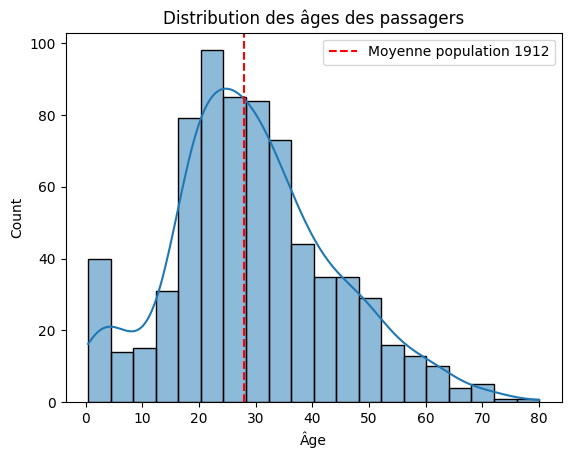

c:\Users\ludom\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


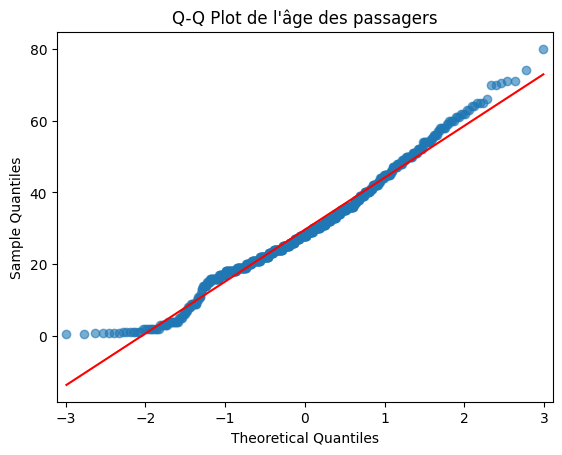

Statistique t = 3.0233009800374053, p-valeur = 0.002590259537786662
Conclusion : On rejette H0 ➡️ l'âge moyen est différent de 28 ans.
Moyenne de l'âge des passagers : 29.64209269662921
Écart-type de l'âge des passagers : 14.49293290032352
Cohen's d = 0.11330299449551398
Conclusion : L'effet est faible ➡️ pas de différence significative.
Moyenne après suppression des outliers : 29.16572443181818
Médiane d'âge : 28.0
Proportion des passagers de moins de 20 ans : 23.03370786516854%
Proportion des passagers entre 20 et 59 ans : 73.45505617977528%
Proportion des passagers de 60 ans et plus : 3.51123595505618%


In [30]:
# 1. Visualisation de la distribution des âges
sns.histplot(data_clean["Age"], kde=True)
plt.axvline(28, color='red', linestyle='--', label='Moyenne population 1912')
plt.legend()
plt.title("Distribution des âges des passagers")
plt.xlabel("Âge")
plt.show()

# 2. Vérification de la normalité avec un Q-Q plot
sm.qqplot(data_clean["Age"], line='s', marker='o', color='blue', alpha=0.6)
plt.title("Q-Q Plot de l'âge des passagers")
plt.show()

# 3. Test t pour une moyenne
t_stat, p_value = ttest_1samp(data_clean["Age"], popmean=28)
print(f"Statistique t = {t_stat}, p-valeur = {p_value}")

# 4. Décision
alpha = 0.05
if p_value < alpha:
    print("Conclusion : On rejette H0 ➡️ l'âge moyen est différent de 28 ans.")
else:
    print("Conclusion : On ne rejette pas H0 ➡️ pas de différence significative.")

# 5. Calcul de la moyenne et de l'écart-type
mean_age = data_clean["Age"].mean()
std_age = data_clean["Age"].std()
print(f"Moyenne de l'âge des passagers : {mean_age}")
print(f"Écart-type de l'âge des passagers : {std_age}")

# 6. Taille de l'effet : Cohen's d
cohen_d = (mean_age - 28) / std_age
print(f"Cohen's d = {cohen_d}")

print("Conclusion : L'effet est faible ➡️ pas de différence significative.")

# Suppression des valeurs extrêmes (outliers) dans la variable `Age`
Q1 = data_clean["Age"].quantile(0.25)
Q3 = data_clean["Age"].quantile(0.75)
IQR = Q3 - Q1

# Définition des limites
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrer les âges dans les limites acceptables
data_filtered = data_clean[(data_clean["Age"] >= lower_bound) & (data_clean["Age"] <= upper_bound)]

# Calcul de la nouvelle moyenne
mean_filtered = data_filtered["Age"].mean()
print(f"Moyenne après suppression des outliers : {mean_filtered}")


# Calcul de la médiane
median_age = data_clean["Age"].median()
print(f"Médiane d'âge : {median_age}")



# Comparaison avec les données de l'Insee : 
total_passagers = data_clean["Age"].count()

# Tranches d'âge
moins_20 = data_clean[data_clean["Age"] < 20].count()["Age"]
entre_20_59 = data_clean[(data_clean["Age"] >= 20) & (data_clean["Age"] < 60)].count()["Age"]
plus_60 = data_clean[data_clean["Age"] >= 60].count()["Age"]

# Calcul des pourcentages
pct_moins_20 = (moins_20 / total_passagers) * 100
pct_entre_20_59 = (entre_20_59 / total_passagers) * 100
pct_plus_60 = (plus_60 / total_passagers) * 100

# Affichage des résultats
print(f"Proportion des passagers de moins de 20 ans : {pct_moins_20}%")
print(f"Proportion des passagers entre 20 et 59 ans : {pct_entre_20_59}%")
print(f"Proportion des passagers de 60 ans et plus : {pct_plus_60}%")




---

**Q2: La survie dépend-elle de la classe du passager?**

Q2 : 
1. Identifier la ou les variables d'intérêt et spécifier le type.
Pour déterminer si la survie dépend de la classe du passager, nous utilisons les variables "Survived" (qui est qualitative binaire) et Pclass qui est qualitative ordinale (1, 2 et 3e classe). 

2. Réaliser une visualisation appropriée selon la ou les variables.
Voir graphiques ci-dessous. Nousa avons utilisé un graphique en barres (grouped bar chart) pour montrer le nombre de morts et survivants par classe. En effet, c'est sans doute le graphique le plus approprié pour montrer une relation entre 2 données qualitatives.

3. Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.
Hypothèse nulle (H0) : la survie ne dépend pas de la classe du passager.
Hypothèse alternative (H1) : la survie dépend de la classe du passager.

4. Identifier le test statistique approprié selon les hypothèses énoncées.
Pour cette deuxième question, nous avons deux variables qualitatives (survie ou non du passager, classe du passager). Dans ce cas, nous utilisons le "Chi Square Test" pour déterminer la relation entre ces 2 variables qualitatives. 

5. Vérifier la validation des assumptions selon le test identifié.
Pour valider les assumptions,  nous devons dans ce cas : 
    s'assurer que les échantillons sont aléatoires
    s'assurer d'avoir au moins 5 valeurs ou 5 "contingences" dans les données des 2 variables. 

Dans notre code, le test chi2_contingency de scipy calcule automatiquement ces effectifs attendus, et nous valide que l'assumption est respectée : les effectifs théoriques sont tous suffisamment grands.

6. Calculer la statistique ainsi que la p-valeur.
La p-valeur obtenue est de 0.000.

7. Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%.
La p-valeur est très largement inférieure à 0.05 : on rejette l'hypothèse nulle selon laquelle la survie du passager ne dépend pas de sa classe. Il existe une relation significative entre la classe du passager et sa probabilité de survie.

8. Interpréter le résultat et évaluer la taille de l'effet.
Selon nos résultats, nous arrivons aux conclusions suivantes : 
- Les passagers de première classe ont survécu en plus grande proportion (65% de survie selon les données à disposition) que ceux de 2e (48%) et 3e classe (24%).
- Ceux de 3e classe ont les chances de survie les plus basses : ils ont le taux de survie le plus bas.

Nous proposons les interprétations suivantes : les passagers de 1ère classe avaient accès plus rapidement et facilement aux canots de sauvetage. Leurs chambres étaient plus proches des ponts supérieurs alors que les passagers de 3e classe, eux, étaient "casés" plus bas dans le bateau. Les passagers de 1ère classe étaient donc plus rapidement mis en sécurité dans les canots, expliquant leur taux de survie plus élevé. 
Aussi, les passagers de 1ère classe avaient certainement un accès prioritaire en raison de leur statut social, en raison des normes de l'époque.


Enfin, il est de notoriété mondiale que le Titanic n'avait pas assez de places dans les canots de sauvetage pour sauver tout le monde à bord. Selon la source citée ci-dessous, le nombre de passagers par classe était le suivant : 
325 en première classe, 285 en deuxième classe et 706 en troisième classe. Etant donné le nombre élevé de passagers de 3e classe et le nombre limité de canots de sauvetage, un plus grand nombre de passagers de 3e classe n'a pas survécu, expliquant aussi le taux bas de survie de ces derniers.

Référence utilisée pour le nombre de passagers par classe : https://www.thecanadianencyclopedia.ca/fr/article/titanic



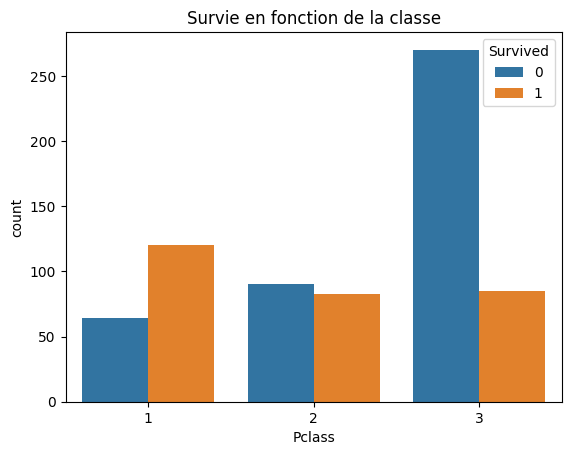

Chi2 = 91.081, p-value = 0.000
Conclusion : On rejette H0 ➡️  la survie dépend de la classe.
Taux de survie par classe :
Classe 1 : 65.22%
Classe 2 : 47.98%
Classe 3 : 23.94%


In [31]:
# Visualisation
sns.countplot(x='Pclass', hue='Survived', data=data_clean)
plt.title("Survie en fonction de la classe")
plt.show()

# Tableau de contingence et test du Chi
contingency_table = pd.crosstab(data_clean["Pclass"], data_clean["Survived"])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2 = {chi2:.3f}, p-value = {p:.3f}")
if p < 0.05:
    print("Conclusion : On rejette H0 ➡️  la survie dépend de la classe.")
else:
    print("Conclusion : on ne rejette pas H0 ➡️ pas de différence significative.")


# Taux de survie par classe
survival_rates = data_clean.groupby("Pclass")["Survived"].mean() * 100
print("Taux de survie par classe :")
for cls, rate in survival_rates.items():
    print(f"Classe {cls} : {rate:.2f}%")


---

**Q3: Existe-t-il une différence d'âge entre les passagers qui ont survécu et les passagers décédés?** 


Références :
- Test de Welch : https://pythonfordatascienceorg.wordpress.com/welch-t-test-python-pandas/


Q3 : 
1. Identifier la ou les variables d'intérêt et spécifier le type.
Les variables à utiliser ici sont : Age et Survived. Age est une variable quantitative continue et Suvived est qualitative binaire (0 ou 1).

2. Réaliser une visualisation appropriée selon la ou les variables.
Nous comparons ici la distribution de l'âge de deux groupes : les survivants et les passagers décédés. Pour ce faire, nous avons donc réalisé un box-plot. 

3. Énoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.
Hypothèse nulle (H0) : Il n’y a pas de différence d’âge moyen entre les survivants et les non-survivants.
Hypothèse alternative(H1) : Il existe une différence d’âge moyen entre les deux groupes

4. Identifier le test statistique approprié selon les hypothèses énoncées.
Nous avons deux échantillons : les survivants et les non-survivants. Nous devons donc comparer les moyennes de deux échantillons indépendants. La variance des échantillons n'est pas connue. La variable "Age" étant quantitative, c'est le t-test qui est le plus approprié.

5. Vérifier la validation des assumptions selon le test identifié.
Pour ce t-test, on doit vérifier deux principales hypothèses :
Indépendance des observations : Chaque passager est une personne différente. C'est en ordre ici.
Normalité des distributions : La normalité de l'âge peut être examinée par un Q-Q plot pour chaque groupe (survivants et non survivants). Ici, les points suivent approximativement la diagonale, donc la normalité est raisonnablement respectée.

6. Calculer la statistique ainsi que la p-valeur.
Statistique t : 2.184
p-valeur : 0.029

7. Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%.
On rejette l'hypothèse nulle, car évidemment, 0.029 est inférieur à 0.05. Il y a donc une différence significative d'âge entre les survivants et les passagers décédés.

8. Interpréter le résultat et évaluer la taille de l'effet.
Les résultats montrent une différence "statistiquement" significative entre l'âge moyen des passagers survivants et celui des non survivants (t = 2.184, p-valeur = 0.029).Cependant, la taille de l’effet, mesurée par le Cohen’s d, est de -0.168, ce qui correspond à un effet très faible (proche de 0).
Le signe négatif indique simplement que les passagers survivants sont en moyenne un peu plus jeunes que ceux qui ne l’ont pas été. On peut lier ceci au fait que les femmes et les enfants étaient priorisés pour monter sur les canots de sauvetage. Cela a donc joué un rôle sur l'âge des survivants, moins âgés donc que les décédés. Cependant, la différence d’âge reste faible.

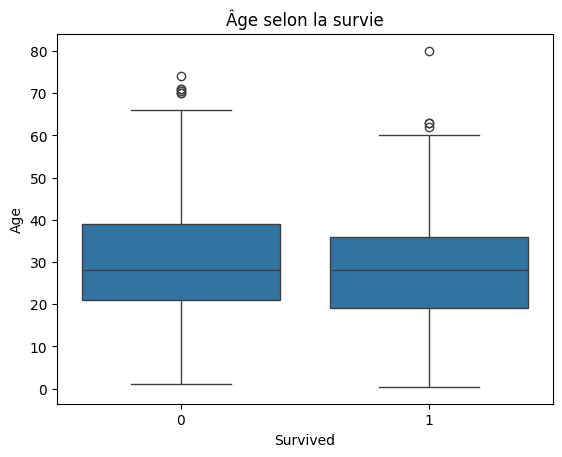

t = 2.184, p-value = 0.029
conclusion : on rejette H0 ➡️ différence significative d'âge.


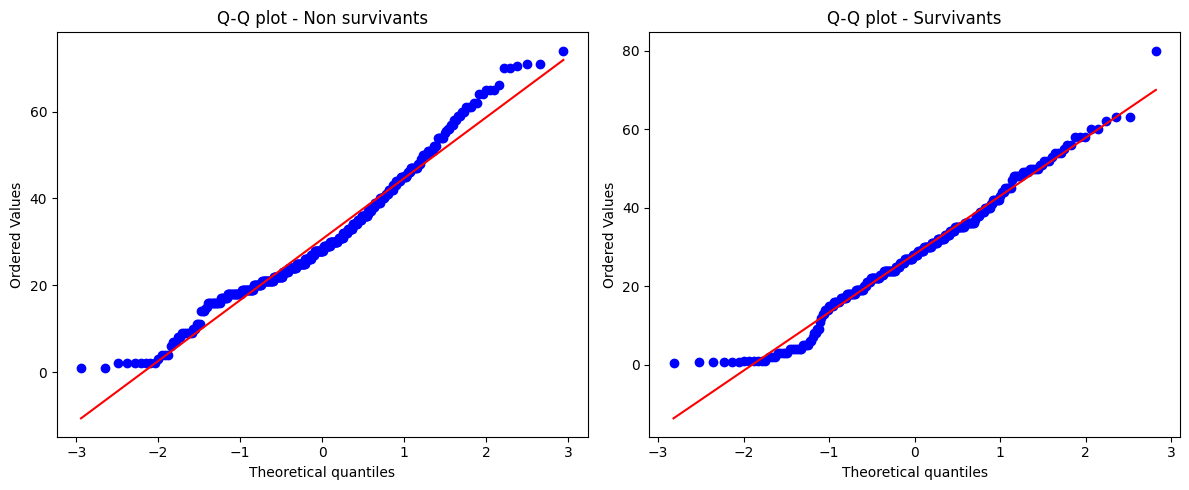

Cohen's d = -0.1683216395507548


In [32]:
# Visualisation
sns.boxplot(x="Survived", y="Age", data=data_clean)
plt.title("Âge selon la survie")
plt.show()

# Test t d'indépendance
group_not_survived = data_clean.loc[data_clean["Survived"] == 0, "Age"]
group_survived = data_clean.loc[data_clean["Survived"] == 1, "Age"]
t_statistic, p_value_diff_age = ttest_ind(group_not_survived, group_survived, equal_var=False)
print(f"t = {t_statistic:.3f}, p-value = {p_value_diff_age:.3f}")
if p_value_diff_age < alpha:
    print("conclusion : on rejette H0 ➡️ différence significative d'âge.")
else:
    print("conclusion : on ne rejette pas H0 ➡️ pas de différence significative.")


# Q-Q plot pour les passagers non survivants
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
stats.probplot(group_not_survived.dropna(), dist="norm", plot=plt)
plt.title("Q-Q plot - Non survivants")

# Q-Q plot pour les passagers survivants
plt.subplot(1, 2, 2)
stats.probplot(group_survived.dropna(), dist="norm", plot=plt)
plt.title("Q-Q plot - Survivants")

plt.tight_layout()
plt.show()


mean1 = group_survived.mean()
mean2 = group_not_survived.mean()
std1 = group_survived.std()
std2 = group_not_survived.std()

# Cohen's d pour échantillons indépendants
n1 = len(group_survived)
n2 = len(group_not_survived)
pooled_std = np.sqrt(((n1 - 1)*std1**2 + (n2 - 1)*std2**2) / (n1 + n2 - 2))
cohen_d = (mean1 - mean2) / pooled_std
print(f"Cohen's d = {cohen_d}")

---

**Q4: Existe-t-il une relation entre l'âge des passagers et le prix des billets?**

1. Identifier la/les variables d'intérêts et spécifier le type : les deux variables sont Age (quantitative continue) et Fare (quantitative continue). 
2. Visualisation appropriées : un scatter plot (nuage de pts) a été utilisé avec une ligne de régression. Cela permet de visualiser la tendance entre les deux variables continues. Une régression linéaire simple a été ajouté pour observer la tendance générale.
3. Hypothèses :
    - H0 (hypo null) : il n'existe pas de corrélation linéaire entre l'âge et le prix du billet (corrélation = 0)
    - H1 (hypo alternative) : il existe une corrélation linéaire entre les 2 variables (corrélation != 0)

4. Test stats approprié : le test de corrélation de Pearson a été utilisé, car les deux variables sont quantitatives continues, une relation linéaire est cherchée et la normalité des variables est presque respectée (vérifier via Q-Q plots)
5. Vérification des assomptions : un tracé des Q-Q plots a été fait pour Age et Fare et les données s'éloignent légèrement de la droite, mais la normalité reste raisonnablement acceptable au vu de la taille de l'échantillon. Ainsi le test de Pearson reste valide.
6. Calculs :
    - coefficient de corrélation de Pearson : r = 0.146
    - p-valeur = 0.000
7. décision (alpha = 5%)
    - La p-valeur est inférieure à 0.05 donc on rejette l'hypothèse null (H0). Il existe une relation statistiquement significative entre l'âge et le prix du billet.
8. Interprétation et taille de l'effet : la corrélation est faible r ~= 0.146 mais significative.
    - Cela signifie que les passagers plus vieux ont légèrement tendance à payer un peu plus cher les billets, mais cela reste limité (la relation). L'âge n'est donc pas un prédicteur fort du prix payé.

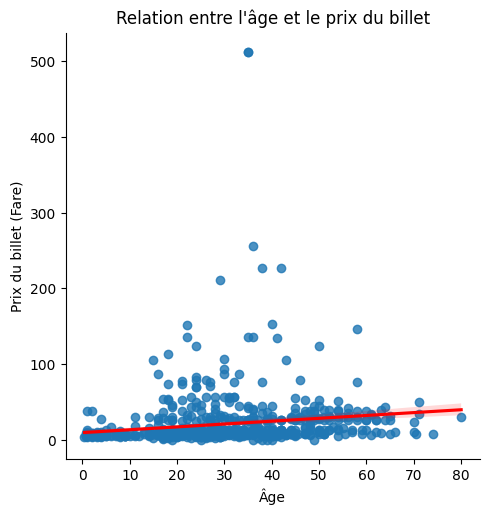

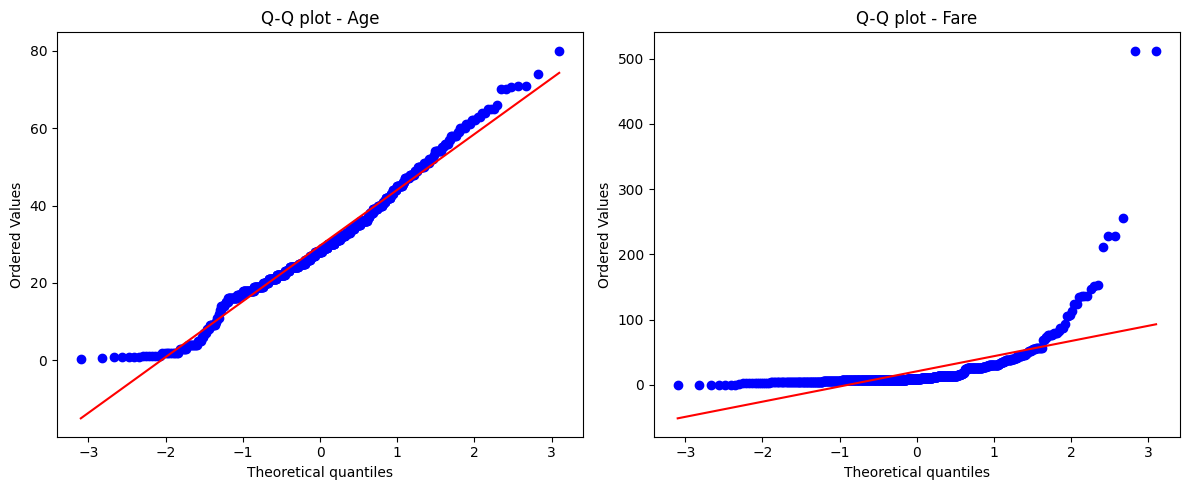

Coefficient de corrélation de Pearson = 0.146, p-value = 0.000
Conclusion : On rejette H0 ➡️ il existe une relation significative entre âge et prix du billet.


In [33]:
#  visualisation scatter plot + régression
sns.lmplot(x="Age", y="Fare", data=data_clean, line_kws={"color": "red"})
plt.title("Relation entre l'âge et le prix du billet")
plt.xlabel("Âge")
plt.ylabel("Prix du billet (Fare)")
plt.show()

#  Q-Q plots pour vérification de la normalité
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
stats.probplot(data_clean["Age"], dist="norm", plot=plt)
plt.title("Q-Q plot - Age")

plt.subplot(1, 2, 2)
stats.probplot(data_clean["Fare"], dist="norm", plot=plt)
plt.title("Q-Q plot - Fare")

plt.tight_layout()
plt.show()

# Calcul de la corrélation de Pearson
corr, pval = pearsonr(data_clean["Age"], data_clean["Fare"])
print(f"Coefficient de corrélation de Pearson = {corr:.3f}, p-value = {pval:.3f}")

# Conclusion statistique
alpha = 0.05
if pval < alpha:
    print("Conclusion : On rejette H0 ➡️ il existe une relation significative entre âge et prix du billet.")
else:
    print("Conclusion : On ne rejette pas H0 ➡️ pas de relation significative détectée.")


Pour chacune des questions 1 à 4 ci-dessus, argumenter de manière statistique en effectuant chacune des étapes suivantes:
1. Identifier la ou les variables d'intérêt et spécifier le type.
2. Réaliser une visualisation appropriée selon la ou les variables.
3. Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.
4. Identifier le test statistique approprié selon les hypothèses énoncées.
5. Vérifier la validation des assumptions selon le test identifié.
6. Calculer la statistique ainsi que la p-valeur.
7. Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%.
8. Interpréter le résultat et évaluer la taille de l'effet.

Quelques liens utiles pour la taille de l'effet:
* [https://rpsychologist.com/cohend/](https://rpsychologist.com/cohend/)
* [https://datatab.net/tutorial/effect-size-independent-t-test](https://datatab.net/tutorial/effect-size-independent-t-test)
* [https://www.simplypsychology.org/effect-size.html](https://www.simplypsychology.org/effect-size.html)

## 3. Data mining (2 pts)

### **Q1: Effectuer une analyse statistique à l'aide de la régression logistique avec comme variable dépendente la variable `Survived`. Interpréter les coefficients et discuter de leur importance statistique en vous appuyant sur leur p-valeur.**

In [34]:
# Sélection des variables explicatives pertinentes
features = ["Pclass", "Age", "Fare", "FamilySize", "Sex_male", "Embarked_Q", "Embarked_S"]
X = data_clean[features]
y = data_clean["Survived"]

# Ajout d'une constante pour l'intercept
X = sm.add_constant(X)

# Régression logistique
model = sm.Logit(y, X).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.445519
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      704
Method:                           MLE   Df Model:                            7
Date:              sam., 12 avr. 2025   Pseudo R-squ.:                  0.3398
Time:                        11:26:04   Log-Likelihood:                -317.21
converged:                       True   LL-Null:                       -480.45
Covariance Type:            nonrobust   LLR p-value:                 1.324e-66
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7251      0.659      8.691      0.000       4.434       7.016
Pclass        -1.1795      0.

#### Interprétation des résultats

`Sex_male`: coef = -2.65, p < 0.001
C'est la variable la plus significative du modèle, être un homme réduit donc fortement les chances de survice. Très fort effet négatif et statistiquement très significatif.

`Pclass`: coef = -1.18, p < 0.001
Les passagers de la troisième classe (réf = première classe) avaient beaucoup moins de chances de survie. Effet fortement négatif et statistiquement significatif.

`Age` : coef = -0.0418, p < 0.001
L'âge a un effet négatif et significatif, plus on est âgé moins on a de chance de survivre. Cet effet était non significatif dans l'analyse initial, donc ici c'est un point important à noter.

`FamilySize`: coef = -0.1834, p = 0.009
Contre intuitif comparé à l'analyse initiale, une famille plus grande est associée à moins de chances de survie. Effet négatif et statistiquement significatif.

`Fare`: coef = +0.003, p = 0.457
Pas significatif. Le prix du billet n'explique pas significativement la survie une fois les autres variables contrôlées. Cela diffère de l'analyse initiale où `Fare`semblait significatif.

`Embarked_Q` et `Embarked_S`: p = 0.165 et 0.128
Pas significatif. Le port d'embarquement n'a pas d'effet clair sur la survie.

Explications possibles : 
Pourquoi être un homme réduit les chances de survie ? Comme expliqué précédemment, les femmes et les enfants étaient priorisés sur les canots de sauvetage, ce qui explique le coefficient négatif pour les hommes.

Pourquoi la classe joue-t-elle un rôle ? Comme expliqué précédemment, l'accès aux canots de sauvetage était plus favorable aux passagers de première classe. L'accès aux ponts supérieurs était limité pour les passagers de 2 et 3e classe.

Pouquoi l'âge joue-t-il un rôle ? Les femmes et les enfants étaient priorisés sur les canots de sauvetage. Aussi, l'âge implique certainement une mobilité réduite pour réagir rapidement aux événements , ce qui peut augmenter le risque de décès.

---

### **Q2: Effecter une analyse statistique à l'aide d'un arbre de classification avec comme variable dépendente la variable `Survived` et une profondeur maximale de 4. Visualiser l'arbre et expliquer quelques décisions.**

#### analyse
L'arbre prédit la probabilité de survie (`Survived`) en se basant sur les branches (hiérarchies).

`Sex_male <= 0.5` -> femme ; c'est la première division de l'arbre (les femmes sont plus susceptibles de survivre).

Pour les femmes, `Pclass <= 2.5` (classe 1 ou 2), les femmes de premières ou secondes classes ont une très bonnes chances (taux) de survie.

`Sex_male > 0.5` -> homme ; la majorité des hommes n'ont pas survécu, sauf exceptions liées à la classe ou à l'âge.

Pour les hommes, `Pclass <= 2.5` + `Age <= 6.5` ; les jeunes garçons de premières ou secondes classes avaient de meilleures chances de survie.

Comme quoi "les femmes et les enfants d'abord" se confirment par les statistiques :) plus sérieusement, l'arbre permet de mettre en évidence les mêmes facteurs clés que dans la régression logistique (sexe, classe et âge (pour les hommes)). L'arbre permet de voir visuellement la prise de décision.

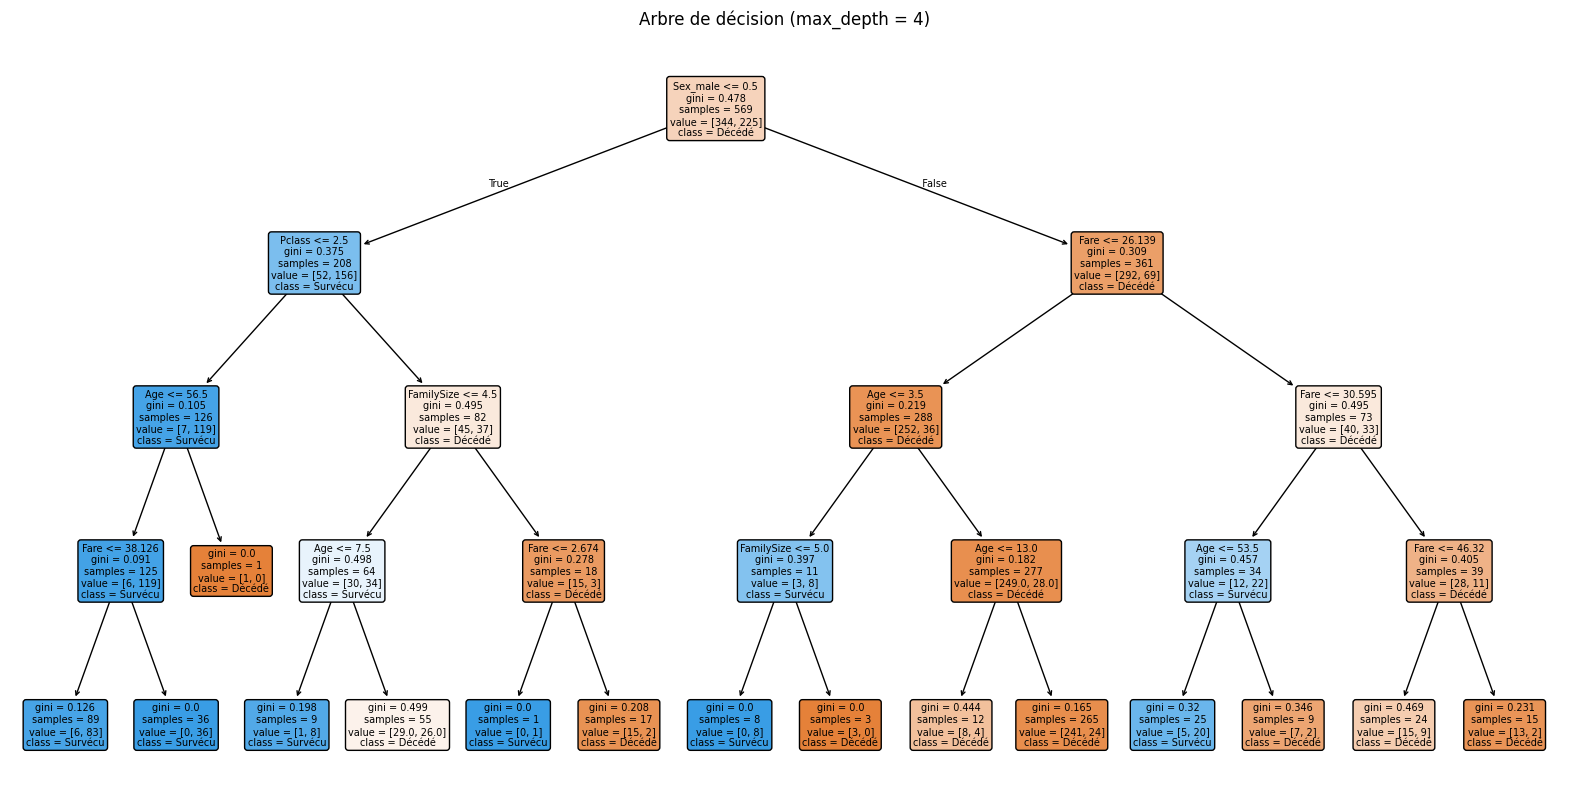

In [35]:
features = ["Pclass", "Age", "Fare", "FamilySize", "Sex_male", "Embarked_Q", "Embarked_S"]
X = data_clean[features]
y = data_clean["Survived"]

# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#arbre de classification avec profondeur max = 4
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)

# Visualiser l’arbre
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=features, class_names=["Décédé", "Survécu"], filled=True, rounded=True)
plt.title("Arbre de décision (max_depth = 4)")
plt.show()


### **Conclusion: Interpréter les résultats des deux analyses statistiques et résumer les points importants de votre étude.**

### Intro
Il a été appliqué deux méthodes de classification pour prédire la survie des passagers du titanic : la régression logistique et un arbre de décision.

#### Comparaison des résultats
La variable la plus influente entre les deux modèles est le sexe (`Sex_male`), et on en conclut qu'être un homme réduit fortement les chances de survie à bord du titanic. Cela est confirmé par le coefficient négatif dans la régression logistique et à la racine de l'arbre.

Les classes ont aussi un effet significatif dans les deux modèles, les passagers de première classe ont davantage de chances de survies que ceux de 2e et 3e classe.

L'âge a aussi son importance, dans la régression l'effet négatif significatif permet de conclure que plus on est âgé, moins on a de chances de survie. Dans l'arbre, ceci a permis d'affiner les décisions pour les hommes (les enfants ont plus de chances de survie).

La taille d'une famille a un effet légèrement négatif dans la régression et dans l'arbre. Elle a peu ou pas d'impact, mais on peut en conclure que les familles nombreuses semblent désavantagées.

Puis les variables `Fare` et `Emarked`ne sont pas significatives dans la régression et peu utilisées dans l'arbre. La conclusion est donc que celles-ci n'expliquent pas bien la survie une fois les autres facteurs contrôlés.

#### Bilan
L'analyse statistique a permis d'identifier les facteurs déterminants de la survie à bord du titanic, sexe, classe et âge sont les principaux prédicteurs. Les résultats sont cohérents (femmes/enfants d'abord et les passagers de la première classe sont favorisés). La régression donne une analyse fine des effets, tandis que l'arbre de décision propose une lecture plus visuelle et utile pour une prise de décision.
